# Population Landscape Visualization

This notebook creates a population landscape visualization by combining:
- 2D factor analysis results (x, y coordinates in political space)
- Population data by municipality

The result shows municipalities in a 2D political space where point size represents population.

In [14]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter
import sqlite3

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 12)

## 1. Load Population Data from JSON

In [15]:
# Load population JSON
with open('data/features/bevoelkerung.json', 'r') as f:
    pop_data = json.load(f)

# Extract dimension info
geo_dim = pop_data['dataset']['dimension']['Kanton (-) / Bezirk (>>) / Gemeinde (......)']
geo_index = geo_dim['category']['index']
geo_labels = geo_dim['category']['label']
values = pop_data['dataset']['value']

print(f"Total geographic entities: {len(geo_index)}")
print(f"Total population values: {len(values)}")

Total geographic entities: 2302
Total population values: 1878432


In [16]:
# Parse population data - THIS IS A MULTIDIMENSIONAL JSON-STAT DATASET
# We need to extract the correct slice for total population

# Get dimension info
key = 'Kanton (-) / Bezirk (>>) / Gemeinde (......)'
geo_dim = pop_data['dataset']['dimension'][key]
geo_index = geo_dim['category']['index']
geo_labels = geo_dim['category']['label']

bev_dim = pop_data['dataset']['dimension']['Bevölkerungstyp']
wohn_dim = pop_data['dataset']['dimension']['Wohnort vor 1 Jahr']
alter_dim = pop_data['dataset']['dimension']['Alter']

# Get dimension sizes for index calculation
n_jahr = 1  # 2024 only
n_geo = len(geo_index)  # 2302 geographic entities
n_bev = len(bev_dim['category']['index'])  # 2 types
n_wohn = len(wohn_dim['category']['index'])  # 4 categories
n_geschlecht = 1  # already filtered
n_alter = len(alter_dim['category']['index'])  # 102 age categories

values = pop_data['dataset']['value']

print(f"Dimensions: Jahr={n_jahr}, Geo={n_geo}, Bev={n_bev}, Wohn={n_wohn}, Geschlecht={n_geschlecht}, Alter={n_alter}")
print(f"Expected total values: {n_jahr * n_geo * n_bev * n_wohn * n_geschlecht * n_alter}")
print(f"Actual values: {len(values)}")

# We want:
# - Bevölkerungstyp = '1' (Ständige Wohnbevölkerung = Permanent residents)
# - Wohnort = '-99999' (Total) 
# - Alter = '-99999' (Total - all ages)

bev_idx = list(bev_dim['category']['index'].keys()).index('1')  # Permanent residents
wohn_idx = list(wohn_dim['category']['index'].keys()).index('-99999')  # Total
alter_idx = list(alter_dim['category']['index'].keys()).index('-99999')  # All ages

print(f"\nUsing indices: Bev={bev_idx}, Wohn={wohn_idx}, Alter={alter_idx}")
print(f"  Bevölkerungstyp='1' = {bev_dim['category']['label']['1']}")
print(f"  Wohnort='-99999' = {wohn_dim['category']['label']['-99999']}")
print(f"  Alter='-99999' = {alter_dim['category']['label']['-99999']}")

# Calculate index in flattened array
# JSON-stat format: values are in row-major order
population_records = []

for code, geo_idx in geo_index.items():
    label = geo_labels[code]
    
    # Only extract municipalities (those with "......" prefix)
    if label.startswith('......'):
        # Extract BFS number from label
        parts = label.replace('......', '').split(' ', 1)
        if len(parts) >= 2:
            bfs_str = parts[0]
            name = parts[1]
            
            try:
                bfs_number = int(bfs_str)  # Convert to int (removes leading zeros)
                
                # Calculate index in values array (row-major order)
                flat_idx = (
                    0 * (n_geo * n_bev * n_wohn * n_geschlecht * n_alter) +  # jahr_idx = 0
                    geo_idx * (n_bev * n_wohn * n_geschlecht * n_alter) +
                    bev_idx * (n_wohn * n_geschlecht * n_alter) +
                    wohn_idx * (n_geschlecht * n_alter) +
                    0 * n_alter +  # geschlecht_idx = 0
                    alter_idx
                )
                
                population = values[flat_idx]
                
                population_records.append({
                    'bfs_number': bfs_number,
                    'municipality_name': name,
                    'population': population
                })
            except (ValueError, IndexError) as e:
                print(f"Error processing {code} ({label}): {e}")
                continue

# Create DataFrame
df_population = pd.DataFrame(population_records)

print(f"\n{'='*80}")
print(f"Municipalities with population data: {len(df_population)}")
print(f"\nPopulation statistics:")
print(df_population['population'].describe())
print(f"\nTop 10 by population:")
df_population.nlargest(10, 'population')[['bfs_number', 'municipality_name', 'population']]

Dimensions: Jahr=1, Geo=2302, Bev=2, Wohn=4, Geschlecht=1, Alter=102
Expected total values: 1878432
Actual values: 1878432

Using indices: Bev=0, Wohn=0, Alter=0
  Bevölkerungstyp='1' = Ständige Wohnbevölkerung
  Wohnort='-99999' = Wohnort vor 1 Jahr - Total
  Alter='-99999' = Alter - Total

Municipalities with population data: 2131

Population statistics:
count      2131.000000
mean       4247.315345
std       13485.682903
min          32.000000
25%         779.000000
50%        1717.000000
75%        4163.500000
max      436551.000000
Name: population, dtype: float64

Top 10 by population:


,bfs_number,municipality_name,population
159,261,Zürich,436551
2056,6621,Genève,209061
888,2701,Basel,177571
1745,5586,Lausanne,144873
344,351,Bern,137995
144,230,Winterthur,120376
495,1061,Luzern,86234
1030,3203,St. Gallen,78863
1538,5192,Lugano,63629
200,371,Biel/Bienne,56896


## 2. Load Factor Analysis Results

In [17]:
# Load 2D factor analysis results
df_factors = pd.read_csv('municipality_political_space_2d.csv')

print(f"Municipalities with factor scores: {len(df_factors)}")
print(f"\nColumns: {df_factors.columns.tolist()}")
print(f"\nSample data:")
df_factors.head(10)

Municipalities with factor scores: 2108

Columns: ['geo_id', 'geo_name', 'factor_1', 'factor_2']

Sample data:


,geo_id,geo_name,factor_1,factor_2
0,4551,Aadorf,0.580959,-0.603949
1,4001,Aarau,-0.825292,-1.365767
2,301,Aarberg,-0.008154,-1.032256
3,4271,Aarburg,0.213051,0.164158
4,321,Aarwangen,0.460718,-0.500674
5,4221,Abtwil,1.202149,-0.103099
6,5621,Aclens,-1.665820,-0.246603
7,5048,Acquarossa,0.044996,1.450371
8,561,Adelboden,1.911180,0.323530
9,1051,Adligenswil,-0.500697,-1.625816


## 3. Join Population with Factor Analysis Results

In [18]:
# Ensure BFS numbers are integers in both dataframes
df_population['bfs_number'] = df_population['bfs_number'].astype(int)
df_factors['geo_id'] = df_factors['geo_id'].astype(int)

# Join on BFS number
df_landscape = df_factors.merge(
    df_population,
    left_on='geo_id',
    right_on='bfs_number',
    how='left'
)

print(f"Total municipalities after join: {len(df_landscape)}")
print(f"Municipalities with population data: {df_landscape['population'].notna().sum()}")
print(f"Municipalities without population data: {df_landscape['population'].isna().sum()}")

# Check for missing population
if df_landscape['population'].isna().sum() > 0:
    print("\nMunicipalities without population data:")
    print(df_landscape[df_landscape['population'].isna()][['geo_id', 'geo_name']].head(10))

df_landscape.head(10)

Total municipalities after join: 2108
Municipalities with population data: 2102
Municipalities without population data: 6

Municipalities without population data:
      geo_id                   geo_name
323     5394  C'za Corticiasca/Valcolla
659     9250        GE-CH de l'étranger
738     2239           Grolley-Ponthaux
956     9030              LU-Ausland-CH
993     6513                     Laténa
1028    5395                       Lema


,geo_id,geo_name,factor_1,factor_2,bfs_number,municipality_name,population
0,4551,Aadorf,0.580959,-0.603949,4551.0,Aadorf,9800.0
1,4001,Aarau,-0.825292,-1.365767,4001.0,Aarau,22710.0
2,301,Aarberg,-0.008154,-1.032256,301.0,Aarberg,4620.0
3,4271,Aarburg,0.213051,0.164158,4271.0,Aarburg,8917.0
4,321,Aarwangen,0.460718,-0.500674,321.0,Aarwangen,4813.0
5,4221,Abtwil,1.202149,-0.103099,4221.0,Abtwil,1120.0
6,5621,Aclens,-1.665820,-0.246603,5621.0,Aclens,585.0
7,5048,Acquarossa,0.044996,1.450371,5048.0,Acquarossa,1796.0
8,561,Adelboden,1.911180,0.323530,561.0,Adelboden,3420.0
9,1051,Adligenswil,-0.500697,-1.625816,1051.0,Adligenswil,5617.0


In [19]:
# Remove municipalities without population data
df_landscape_clean = df_landscape[df_landscape['population'].notna()].copy()

print(f"Final dataset: {len(df_landscape_clean)} municipalities")
print(f"\nPopulation statistics:")
print(df_landscape_clean['population'].describe())

Final dataset: 2102 municipalities

Population statistics:
count      2102.000000
mean       4289.843007
std       13572.365468
min          32.000000
25%         801.000000
50%        1733.500000
75%        4245.250000
max      436551.000000
Name: population, dtype: float64


## 4. Identify Municipalities to Label

We'll label:
1. Top 20 most populous municipalities
2. Political extremes (furthest in each direction on both factors)

In [20]:
# Identify municipalities to label
# 1. Top 20 by population
top_populous = df_landscape_clean.nlargest(20, 'population')

# 2. Political extremes (5 in each direction for each factor)
extremes = pd.concat([
    df_landscape_clean.nsmallest(5, 'factor_1'),  # Leftmost on Factor 1
    df_landscape_clean.nlargest(5, 'factor_1'),   # Rightmost on Factor 1
    df_landscape_clean.nsmallest(5, 'factor_2'),  # Bottom on Factor 2
    df_landscape_clean.nlargest(5, 'factor_2'),   # Top on Factor 2
])

# Combine and remove duplicates
municipalities_to_label = pd.concat([top_populous, extremes]).drop_duplicates(subset='geo_id')

print(f"Total municipalities to label: {len(municipalities_to_label)}")
print(f"\nTop 10 by population:")
print(municipalities_to_label.nlargest(10, 'population')[['geo_name', 'population', 'factor_1', 'factor_2']])

Total municipalities to label: 39

Top 10 by population:
         geo_name  population  factor_1  factor_2
2107       Zürich    436551.0 -1.669500 -0.954105
676        Genève    209061.0 -2.206805  0.881852
116         Basel    177571.0 -1.428923 -0.306745
1002     Lausanne    144873.0 -2.687395  0.544597
158          Bern    137995.0 -2.172746 -0.975054
2043   Winterthur    120376.0 -1.036761 -0.862838
1093       Luzern     86234.0 -1.069077 -1.113509
1726   St. Gallen     78863.0 -0.840541 -1.034913
1077       Lugano     63629.0 -0.286984  1.279707
178   Biel/Bienne     56896.0 -1.580105  0.383437


## 5. Create Population Density Landscape

This creates a "landscape" where population densities add up to create peaks and valleys.
Each municipality contributes to the landscape based on its population, creating density peaks where many people share similar political preferences.

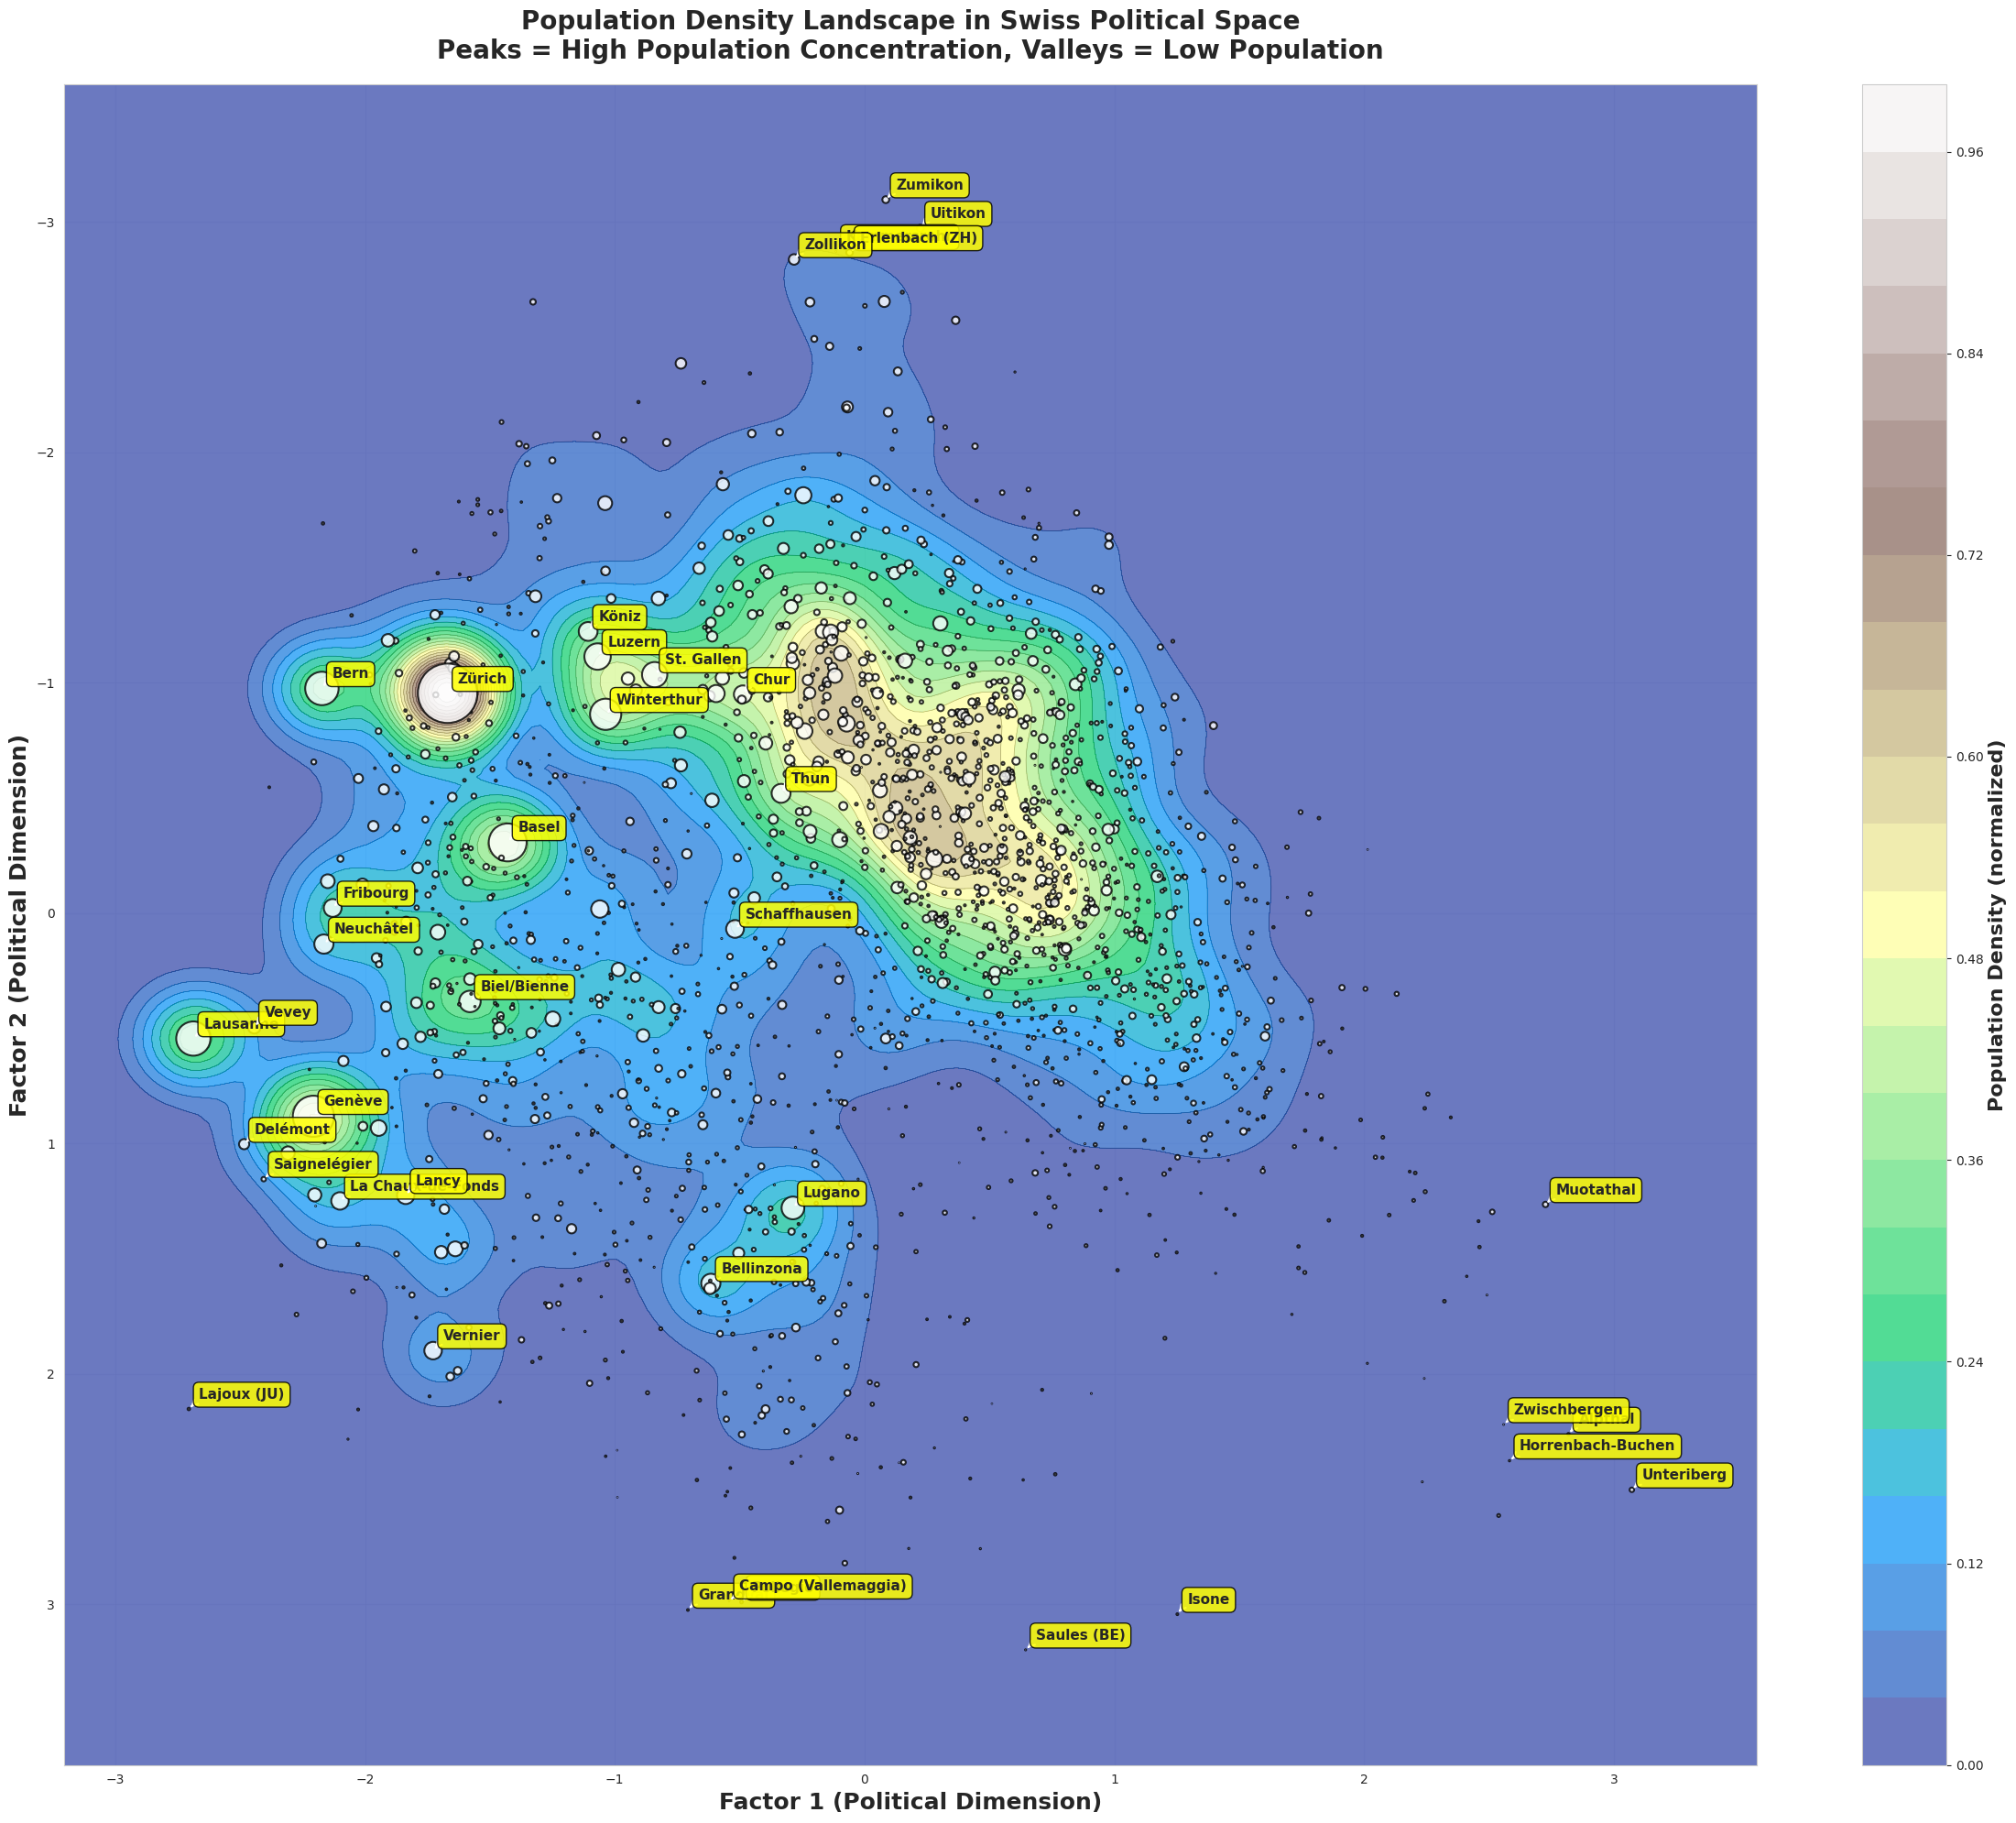

Saved: population_density_landscape.png
Labeled 39 municipalities


In [21]:
# Create 2D population density landscape
fig, ax = plt.subplots(figsize=(24, 20))

# Create grid for density calculation
x = df_landscape_clean['factor_1'].values
y = df_landscape_clean['factor_2'].values
weights = df_landscape_clean['population'].values

# Define grid
x_min, x_max = x.min() - 0.5, x.max() + 0.5
y_min, y_max = y.min() - 0.5, y.max() + 0.5
grid_resolution = 200

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, grid_resolution),
    np.linspace(y_min, y_max, grid_resolution)
)

# Calculate population-weighted density
# For each grid point, sum population based on distance to municipalities
positions = np.vstack([xx.ravel(), yy.ravel()])
density = np.zeros(positions.shape[1])

# Gaussian kernel bandwidth (controls smoothness and reach)
# INCREASED from 0.3 to 0.15 for less smoothing and more pronounced peaks
bandwidth = 0.15

for i, (xi, yi, pop) in enumerate(zip(x, y, weights)):
    # Calculate distance from this municipality to all grid points
    dist_sq = (positions[0] - xi)**2 + (positions[1] - yi)**2
    # Add weighted gaussian contribution
    density += pop * np.exp(-dist_sq / (2 * bandwidth**2))

# Reshape density to grid
density = density.reshape(xx.shape)

# Normalize for better visualization
density = density / density.max()

# Create filled contour plot (the "landscape")
contour_levels = 25  # Increased from 20 for more detail
contour_filled = ax.contourf(
    xx, yy, density,
    levels=contour_levels,
    cmap='terrain',
    alpha=0.7
)

# Add contour lines for clarity
contour_lines = ax.contour(
    xx, yy, density,
    levels=contour_levels,
    colors='black',
    alpha=0.3,
    linewidths=0.5
)

# Add colorbar
cbar = plt.colorbar(contour_filled, ax=ax)
cbar.set_label('Population Density (normalized)', fontsize=16, fontweight='bold')

# Scale population for dot sizes (make them much larger)
df_landscape_clean['dot_size'] = (df_landscape_clean['population'] / 1000) * 5  # Scale factor

# Plot municipalities as dots (larger sizes)
scatter = ax.scatter(
    df_landscape_clean['factor_1'],
    df_landscape_clean['factor_2'],
    s=df_landscape_clean['dot_size'],
    c='white',
    alpha=0.8,
    edgecolors='black',
    linewidth=1.5,
    zorder=5
)

# Label selected municipalities
for idx, row in municipalities_to_label.iterrows():
    # Determine label position to avoid overlap
    ax.annotate(
        row['geo_name'],
        (row['factor_1'], row['factor_2']),
        fontsize=11,
        fontweight='bold',
        xytext=(8, 8),
        textcoords='offset points',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', edgecolor='black', alpha=0.85),
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', lw=1.5),
        zorder=10
    )

# Labels and title
ax.set_xlabel('Factor 1 (Political Dimension)', fontsize=18, fontweight='bold')
ax.set_ylabel('Factor 2 (Political Dimension)', fontsize=18, fontweight='bold')
ax.set_title('Population Density Landscape in Swiss Political Space\nPeaks = High Population Concentration, Valleys = Low Population', 
             fontsize=20, fontweight='bold', pad=20)

# FLIP Y-AXIS UPSIDE DOWN
ax.invert_yaxis()

ax.grid(True, alpha=0.2, zorder=1)

plt.tight_layout()
plt.savefig('population_density_landscape.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: population_density_landscape.png")
print(f"Labeled {len(municipalities_to_label)} municipalities")

## 6. Alternative: 3D Surface Plot

For an even more dramatic "landscape" view, we can create a 3D surface plot where height represents population density.

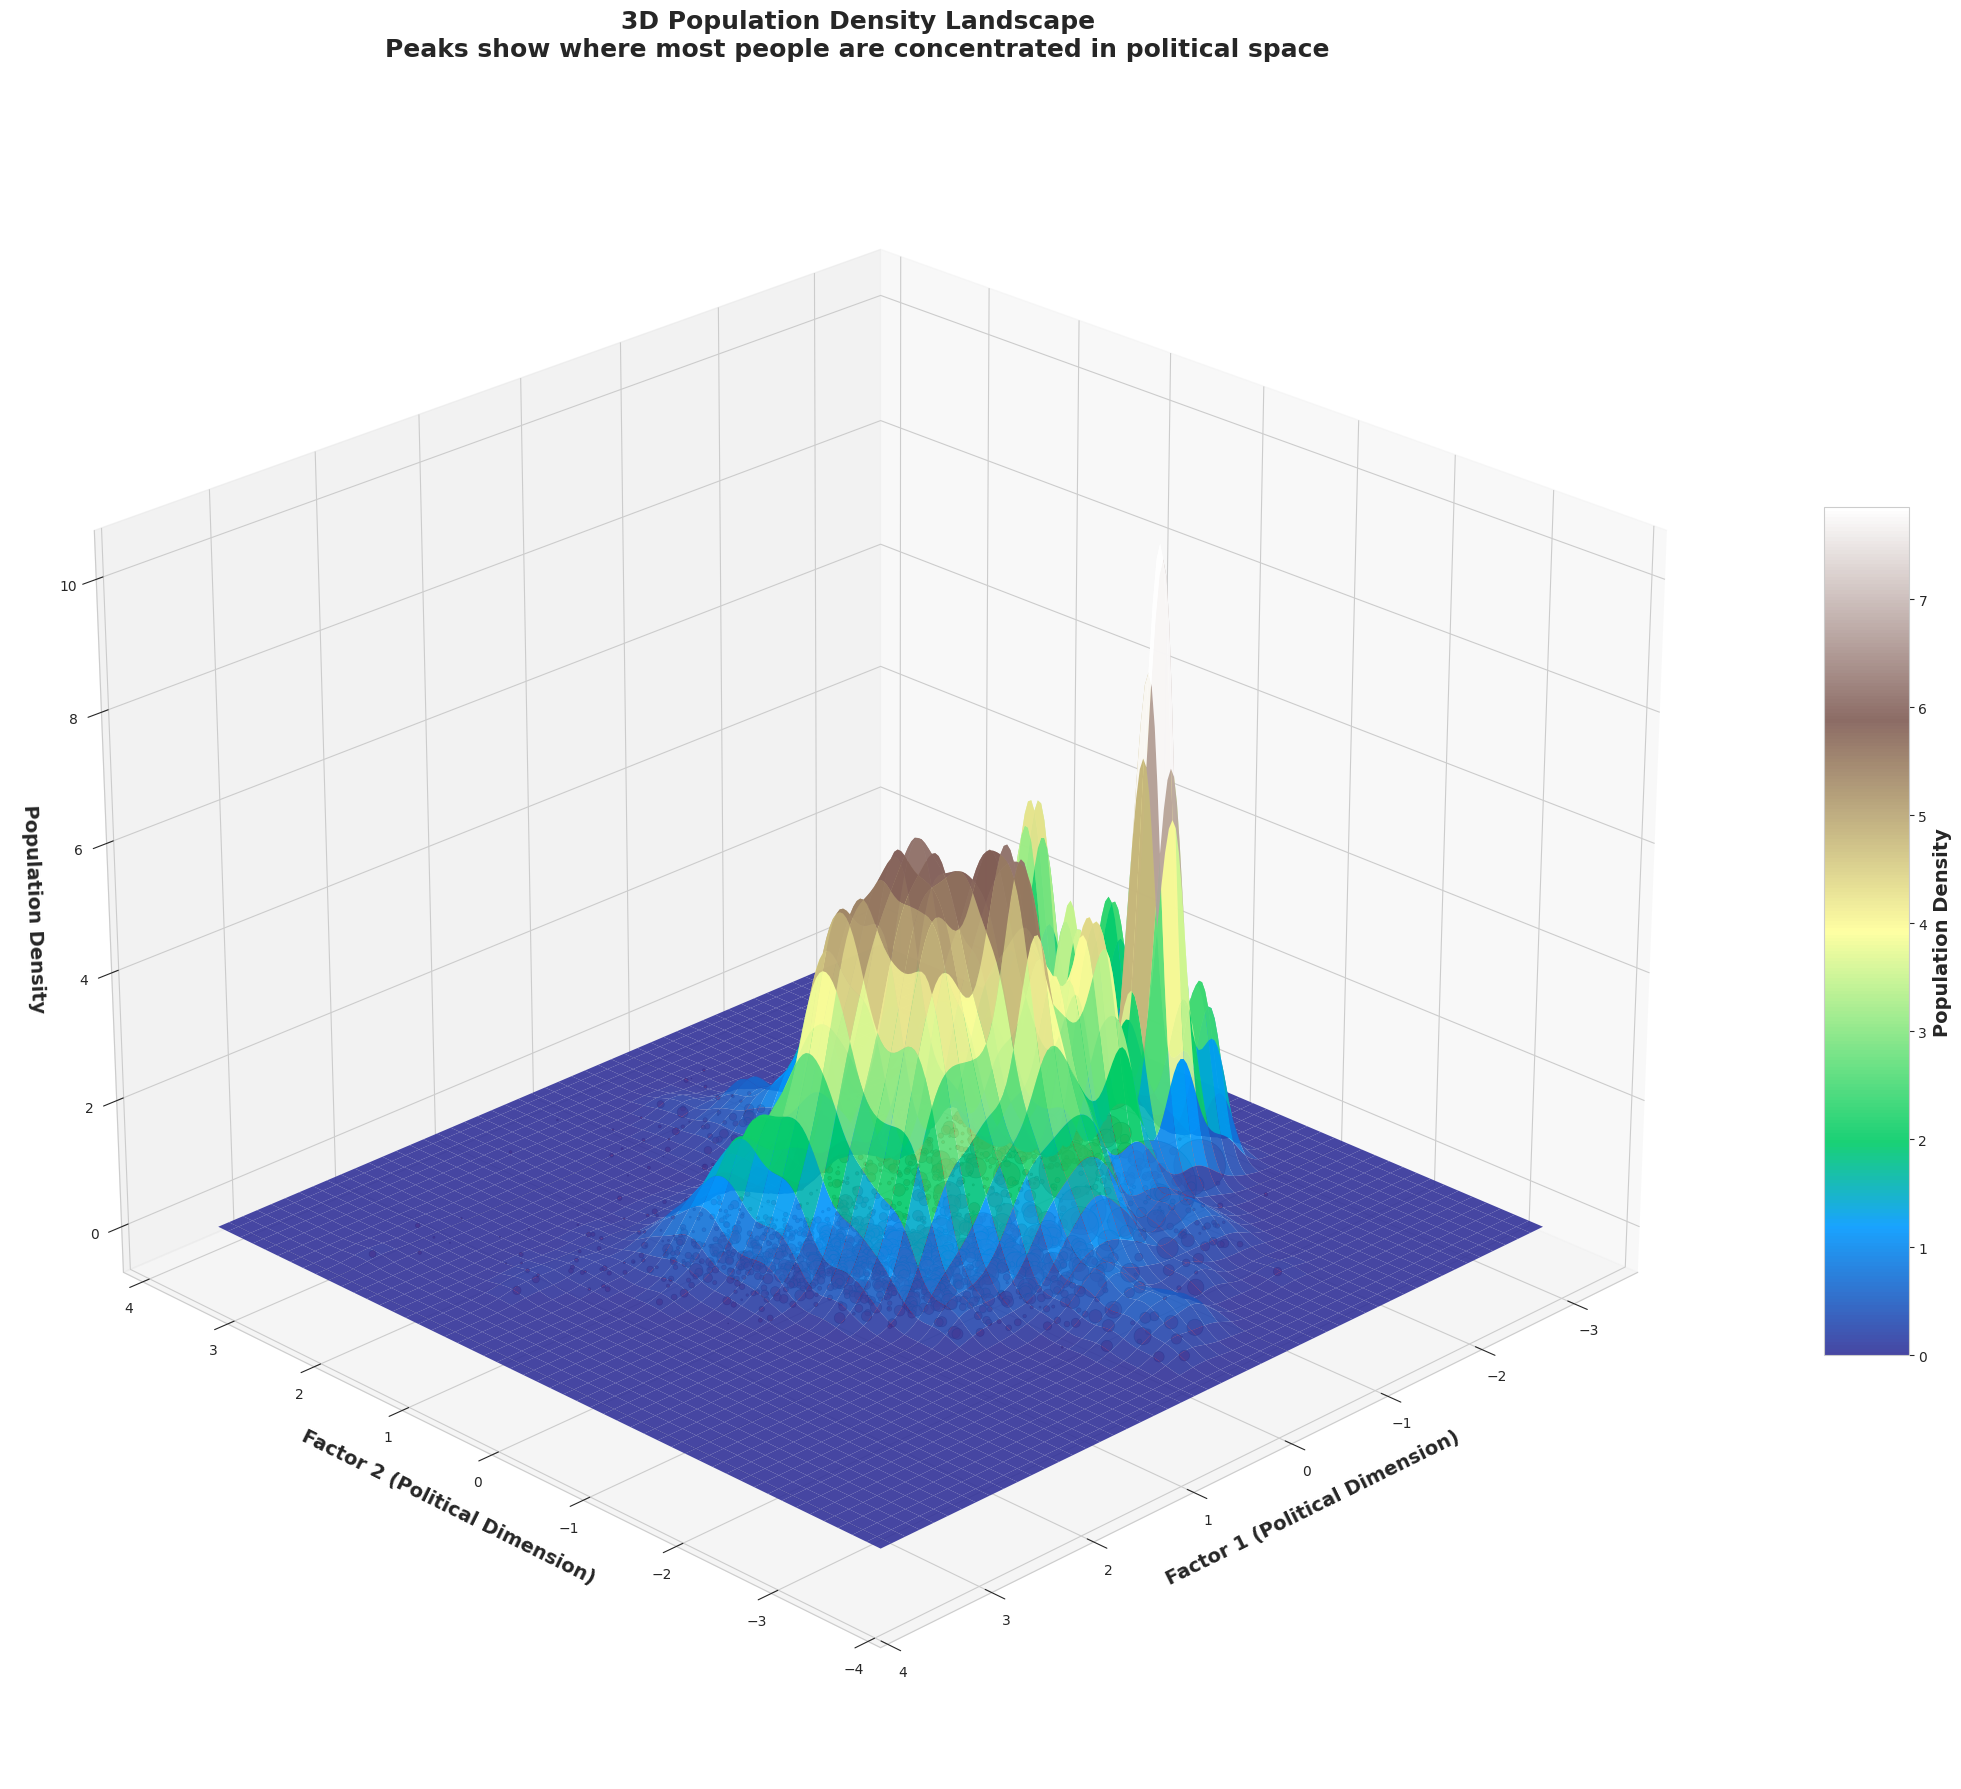

Saved: population_density_landscape_3d.png


In [22]:
# Create 3D surface plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(24, 18))
ax = fig.add_subplot(111, projection='3d')

# Use the same density data from before
# Scale density for better 3D visualization
density_scaled = density * 10

# Create 3D surface
surface = ax.plot_surface(
    xx, yy, density_scaled,
    cmap='terrain',
    alpha=0.9,
    edgecolor='none',
    antialiased=True
)

# Add colorbar
cbar = fig.colorbar(surface, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Population Density', fontsize=14, fontweight='bold')

# Plot municipalities as 3D points
ax.scatter(
    df_landscape_clean['factor_1'],
    df_landscape_clean['factor_2'],
    0,  # Place at z=0 (base of landscape)
    s=df_landscape_clean['dot_size'] * 2,
    c='red',
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5,
    zorder=10
)

# Labels
ax.set_xlabel('Factor 1 (Political Dimension)', fontsize=14, fontweight='bold', labelpad=10)
ax.set_ylabel('Factor 2 (Political Dimension)', fontsize=14, fontweight='bold', labelpad=10)
ax.set_zlabel('Population Density', fontsize=14, fontweight='bold', labelpad=10)
ax.set_title('3D Population Density Landscape\nPeaks show where most people are concentrated in political space', 
             fontsize=18, fontweight='bold', pad=20)

# FLIP Y-AXIS UPSIDE DOWN (invert y-axis limits)
ax.set_ylim(ax.get_ylim()[::-1])

# Adjust viewing angle
ax.view_init(elev=25, azim=45)

plt.tight_layout()
plt.savefig('population_density_landscape_3d.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: population_density_landscape_3d.png")

## 7. Top Municipalities by Population

In [23]:
# Show top 20 municipalities by population with their political positions
top_20 = df_landscape_clean.nlargest(20, 'population')[[
    'geo_id', 'geo_name', 'population', 'factor_1', 'factor_2'
]].copy()

top_20['rank'] = range(1, 21)
top_20 = top_20[['rank', 'geo_id', 'geo_name', 'population', 'factor_1', 'factor_2']]

print("Top 20 Municipalities by Population:")
print("=" * 90)
top_20

Top 20 Municipalities by Population:


,rank,geo_id,geo_name,population,factor_1,factor_2
2107,1,261,Zürich,436551.0,-1.669500,-0.954105
676,2,6621,Genève,209061.0,-2.206805,0.881852
116,3,2701,Basel,177571.0,-1.428923,-0.306745
1002,4,5586,Lausanne,144873.0,-2.687395,0.544597
158,5,351,Bern,137995.0,-2.172746,-0.975054
2043,6,230,Winterthur,120376.0,-1.036761,-0.862838
1093,7,1061,Luzern,86234.0,-1.069077,-1.113509
1726,8,3203,St. Gallen,78863.0,-0.840541,-1.034913
1077,9,5192,Lugano,63629.0,-0.286984,1.279707
178,10,371,Biel/Bienne,56896.0,-1.580105,0.383437


## 8. Political Extremes

In [24]:
# Show municipalities at political extremes
print("Political Extremes (Factor 1):")
print("=" * 90)
print("\nLowest Factor 1 (Left extreme):")
print(df_landscape_clean.nsmallest(5, 'factor_1')[['geo_name', 'population', 'factor_1', 'factor_2']])
print("\nHighest Factor 1 (Right extreme):")
print(df_landscape_clean.nlargest(5, 'factor_1')[['geo_name', 'population', 'factor_1', 'factor_2']])

print("\n" + "=" * 90)
print("\nPolitical Extremes (Factor 2):")
print("=" * 90)
print("\nLowest Factor 2 (Bottom extreme):")
print(df_landscape_clean.nsmallest(5, 'factor_2')[['geo_name', 'population', 'factor_1', 'factor_2']])
print("\nHighest Factor 2 (Top extreme):")
print(df_landscape_clean.nlargest(5, 'factor_2')[['geo_name', 'population', 'factor_1', 'factor_2']])

Political Extremes (Factor 1):

Lowest Factor 1 (Left extreme):
          geo_name  population  factor_1  factor_2
979    Lajoux (JU)       720.0 -2.705590  2.152405
1002      Lausanne    144873.0 -2.687395  0.544597
460       Delémont     12813.0 -2.484131  1.003008
1923         Vevey     20142.0 -2.443599  0.494890
1577  Saignelégier      2531.0 -2.405686  1.154712

Highest Factor 1 (Right extreme):
               geo_name  population  factor_1  factor_2
1868         Unteriberg      2476.0  3.071651  2.503207
38              Alpthal       632.0  2.817853  2.261464
1214          Muotathal      3583.0  2.726010  1.264524
839   Horrenbach-Buchen       224.0  2.581687  2.376933
2105       Zwischbergen        71.0  2.558237  2.219878


Political Extremes (Factor 2):

Lowest Factor 2 (Bottom extreme):
            geo_name  population  factor_1  factor_2
2096         Zumikon      5754.0  0.084748 -3.096709
1862         Uitikon      5699.0  0.222658 -2.972657
902      Kammersrohr        32.0

## 9. Export Final Dataset

In [25]:
# Export final combined dataset
df_landscape_clean.to_csv('municipality_political_space_with_population.csv', index=False)
print("Exported: municipality_political_space_with_population.csv")
print(f"Shape: {df_landscape_clean.shape}")
print(f"Columns: {df_landscape_clean.columns.tolist()}")

Exported: municipality_political_space_with_population.csv
Shape: (2102, 8)
Columns: ['geo_id', 'geo_name', 'factor_1', 'factor_2', 'bfs_number', 'municipality_name', 'population', 'dot_size']


## 10. Summary Statistics

In [26]:
print("=" * 90)
print("POPULATION LANDSCAPE ANALYSIS SUMMARY")
print("=" * 90)
print(f"\nTotal municipalities analyzed: {len(df_landscape_clean)}")
print(f"Municipalities labeled: {len(municipalities_to_label)}")
print(f"\nPopulation statistics:")
print(f"  Total population: {df_landscape_clean['population'].sum():,.0f}")
print(f"  Mean: {df_landscape_clean['population'].mean():,.0f}")
print(f"  Median: {df_landscape_clean['population'].median():,.0f}")
print(f"  Min: {df_landscape_clean['population'].min():,.0f}")
print(f"  Max: {df_landscape_clean['population'].max():,.0f}")
print(f"\nPolitical space (Factor 1):")
print(f"  Range: [{df_landscape_clean['factor_1'].min():.3f}, {df_landscape_clean['factor_1'].max():.3f}]")
print(f"  Mean: {df_landscape_clean['factor_1'].mean():.3f}")
print(f"\nPolitical space (Factor 2):")
print(f"  Range: [{df_landscape_clean['factor_2'].min():.3f}, {df_landscape_clean['factor_2'].max():.3f}]")
print(f"  Mean: {df_landscape_clean['factor_2'].mean():.3f}")
print("\nOutput files created:")
print("  - population_density_landscape.png (2D contour map with labels)")
print("  - population_density_landscape_3d.png (3D surface plot)")
print("  - municipality_political_space_with_population.csv (data export)")
print("=" * 90)

POPULATION LANDSCAPE ANALYSIS SUMMARY

Total municipalities analyzed: 2102
Municipalities labeled: 39

Population statistics:
  Total population: 9,017,250
  Mean: 4,290
  Median: 1,734
  Min: 32
  Max: 436,551

Political space (Factor 1):
  Range: [-2.706, 3.072]
  Mean: 0.003

Political space (Factor 2):
  Range: [-3.097, 3.198]
  Mean: -0.001

Output files created:
  - population_density_landscape.png (2D contour map with labels)
  - population_density_landscape_3d.png (3D surface plot)
  - municipality_political_space_with_population.csv (data export)
